In [243]:
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.5 umap==0.4.6 numpy==1.19.4 scipy==1.5.4 pandas==1.1.5 scikit-learn==0.24.0 statsmodels==0.12.1 python-igraph==0.8.2 louvain==0.7.0 leidenalg==0.8.2


# Data integration
Data: Organoids were derived from fetal ileum from embryos aged 5.4 and 6.4 PCW (BRC2038, BRC2039) and were maintained in vitro. Single-cell profiling using 10x 3’v2 Genomics was applied to these cultures once they were first established (after one week, passage 1) and following 4-5 months in culture (17 passages). This data was aligned to the GRCh38-1.2.0 human reference transcriptome using the Cellranger v2.1.1 pipeline (10x Genomics) with default parameters.

Here we integrate the organoid samples and perform basic QC. 

In [5]:
org_meta = pd.read_table('/mnt/Dec2020/2020_org_sample_track.txt', index_col = 0)

In [6]:
org_meta[0:4]

sample_id Condition   source
Run ID                                      
4918STDY7426910  TIp12038        p1  PCW 6.4
4918STDY7426911  TIp12039        p1  PCW 5.4
4918STDY7590324   p172038       p17  PCW 6.4
4918STDY7590325   p172039       p17  PCW 5.4

In [85]:
path = '/mnt/PROJECTS/Unprocessed_all/'
filenames = org_meta[0:4].index
adatas = [sc.read_10x_mtx(path + filename + '/cellranger/', cache = True, make_unique = True) for filename in filenames]
for i in range(len(adatas)):
    adatas[i].obs['sample'] = org_meta.index[i]
    for col in org_meta.columns:
        adatas[i].obs[col] = org_meta[col][i]
adata = adatas[0].concatenate(adatas[1:], batch_categories = org_meta.index)

... reading from cache file cache/mnt-PROJECTS-Unprocessed_all-4918STDY7426910-cellranger-matrix.h5ad
... reading from cache file cache/mnt-PROJECTS-Unprocessed_all-4918STDY7426911-cellranger-matrix.h5ad
... reading from cache file cache/mnt-PROJECTS-Unprocessed_all-4918STDY7590324-cellranger-matrix.h5ad
... reading from cache file cache/mnt-PROJECTS-Unprocessed_all-4918STDY7590325-cellranger-matrix.h5ad


In [86]:
adata

AnnData object with n_obs × n_vars = 9307 × 33694
    obs: 'sample', 'sample_id', 'Condition', 'source', 'batch'
    var: 'gene_ids'

In [8]:
adata.write('/mnt/Dec2020/fetal_organoidp1p17.h5ad')

... storing 'sample' as categorical
... storing 'sample_id' as categorical
... storing 'Condition' as categorical
... storing 'source' as categorical


General QC folowing scanpy notebooks

In [87]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14256 genes that are detected in less than 3 cells


In [88]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

... storing 'sample' as categorical
... storing 'sample_id' as categorical
... storing 'Condition' as categorical
... storing 'source' as categorical


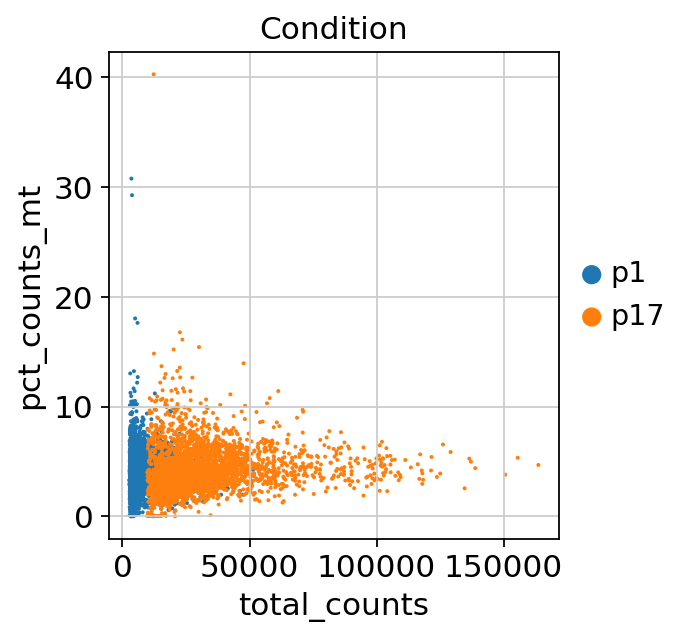

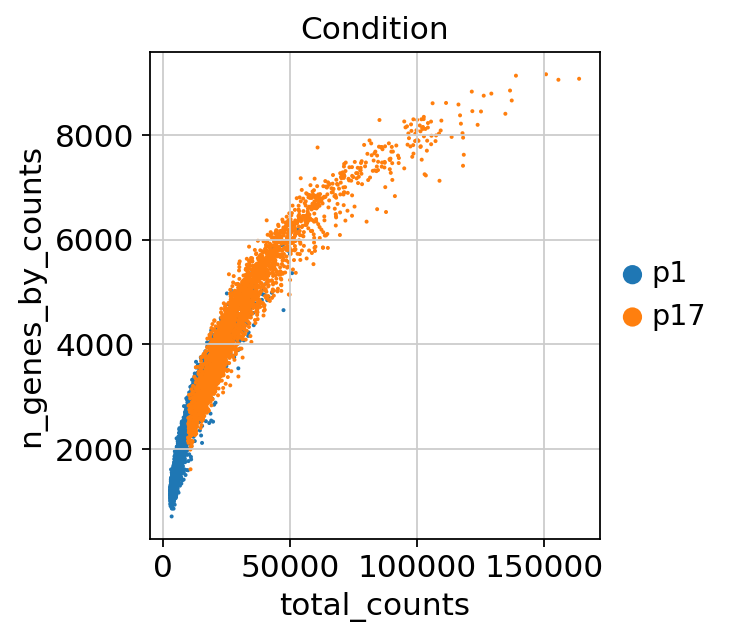

In [89]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color="Condition")
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color="Condition")

In [90]:
#There are very few cells that have high mt content. 
#This is very low given that they are epithelial cells. I choose to keep them for the initial clustering.

adata = adata[adata.obs.n_genes_by_counts < 8000, :]
#adata = adata[adata.obs.pct_counts_mt < 5, :]

In [91]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata

normalizing counts per cell


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


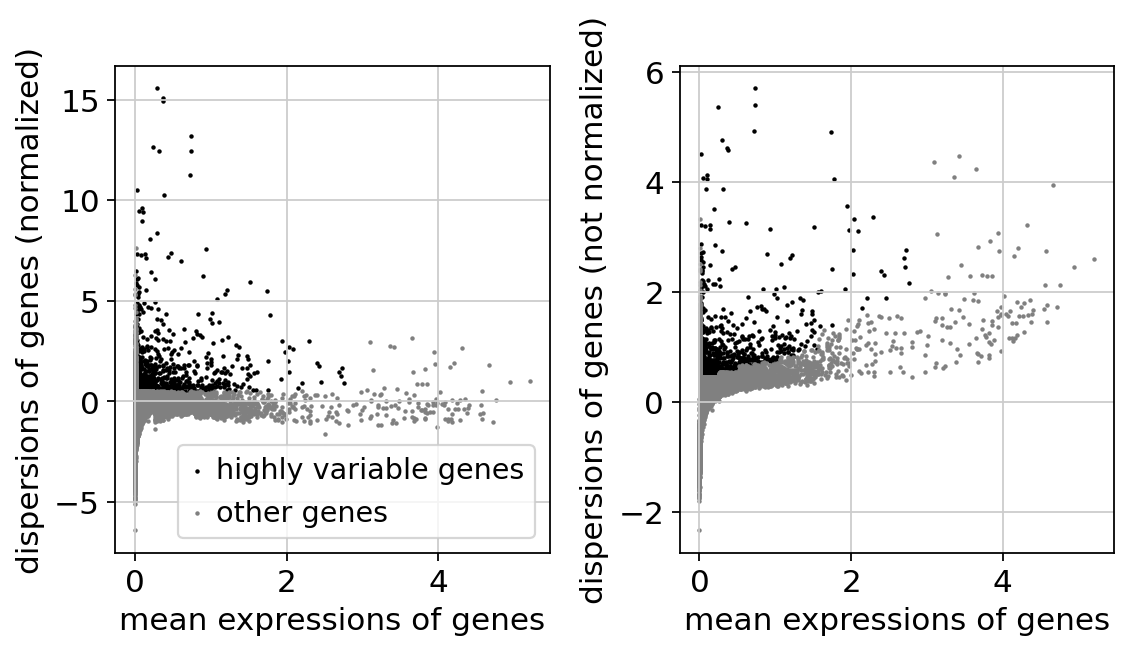

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:17)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


In [92]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)
sc.tl.pca(adata, svd_solver='arpack')

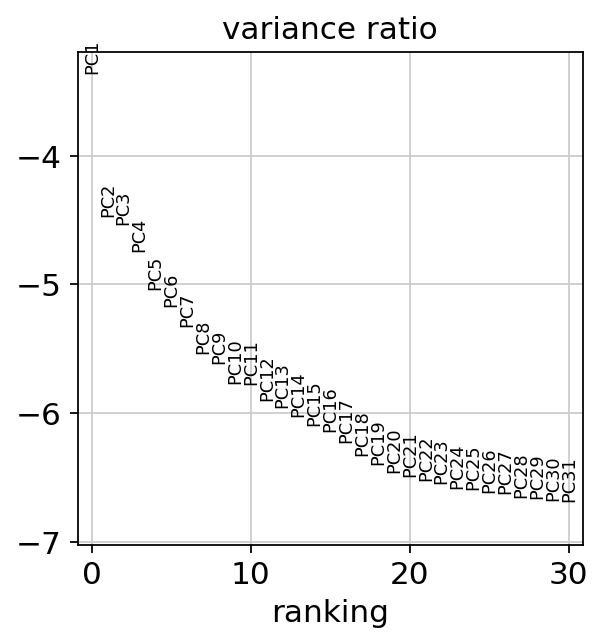

In [93]:
sc.pl.pca_variance_ratio(adata, log=True)

In [94]:
import bbknn
bbknn.bbknn(adata, batch_key='batch', neighbors_within_batch=3, 
            metric='euclidean', n_pcs=50)
sc.tl.umap(adata)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:01)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:19)


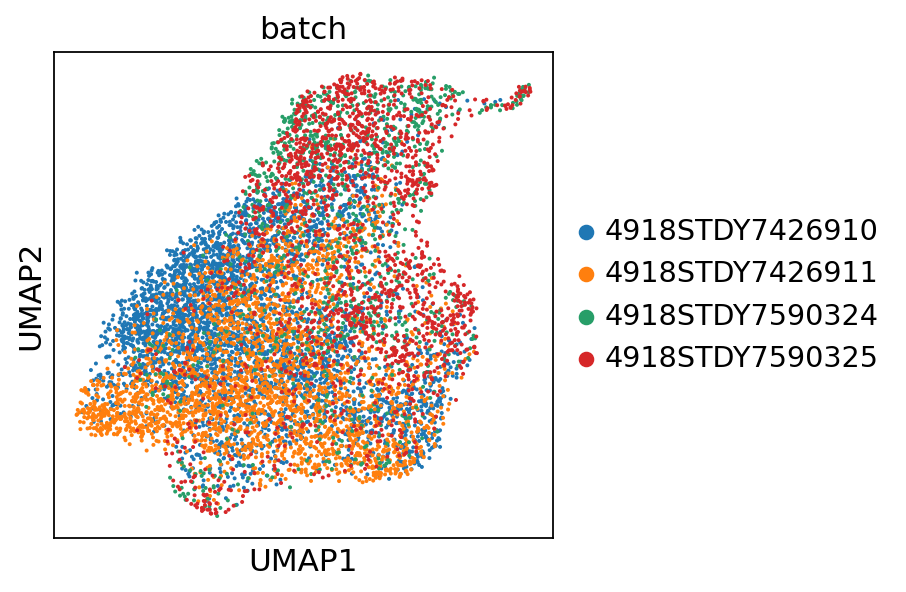

In [95]:
sc.pl.umap(adata, color="batch")

In [96]:
#Score cell cycle phase
cell_cycle_genes = [x.strip() for x in open('/mnt/PROJECTS/SCP/Data_analysis/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]

sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes, use_raw=True)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    600 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    468 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


... storing 'phase' as categorical


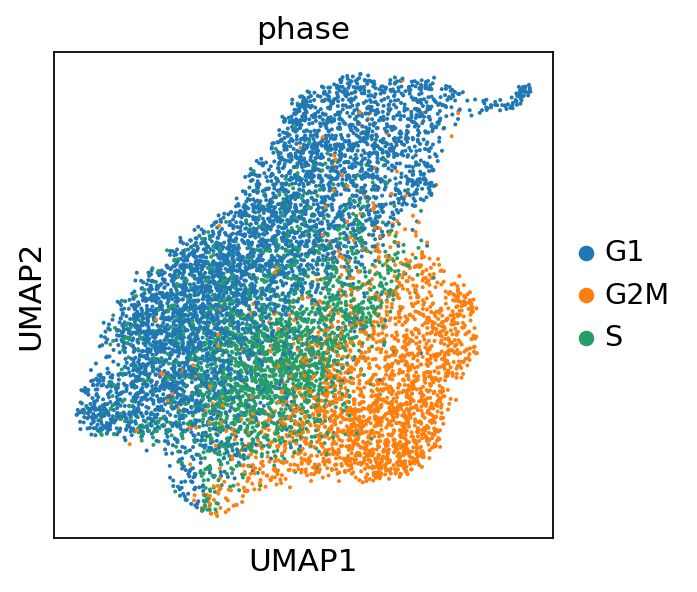

In [97]:
sc.pl.umap(adata, color="phase")

In [240]:
adata.write('/mnt/Dec2020/fetal_organoidp1p17_normalised.h5ad')

In [296]:
#Add cell type predictions to the adata object
pred_out = pd.read_csv("/mnt/PROJECTS/Fetal_paper/labels_2_final.csv")
org = pd.DataFrame(pred_out)
org = org.rename(columns = {'0_x': 'index'})
org = org.set_index('index')
adata.obs["pred"] = [str(x) for x in org["0_y"]]

In [297]:
#Update the annotations from the previous version
adata.obs["pred"] = adata.obs["pred"].replace("Primitive Epi", "Uniform progenitor")
adata.obs["pred"] = adata.obs["pred"].replace("cycling cells 1", "G2M phase")
adata.obs["pred"] = adata.obs["pred"].replace("cycling cells 2", "S phase")
adata.obs["pred"] = adata.obs["pred"].replace("enteroendocrine 2", "NTS+ cells")
adata.obs["pred"] = adata.obs["pred"].replace("BEST4 enterocyte prog", "BEST4 enterocyte")
adata.obs["pred"] = adata.obs["pred"].replace("Goblet prog", "Goblet progenitor")

... storing 'pred' as categorical


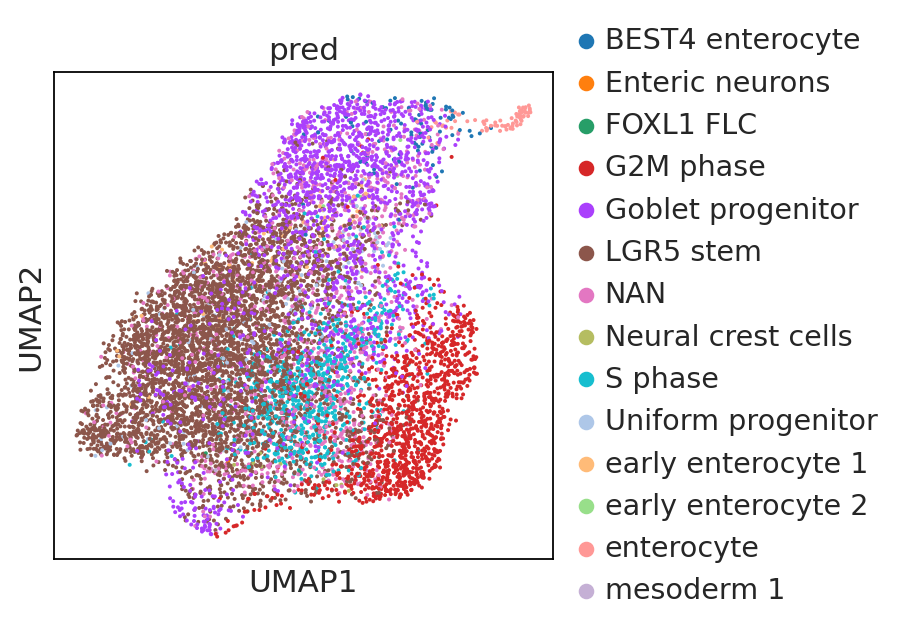

In [298]:
sc.pl.umap(adata, color="pred")

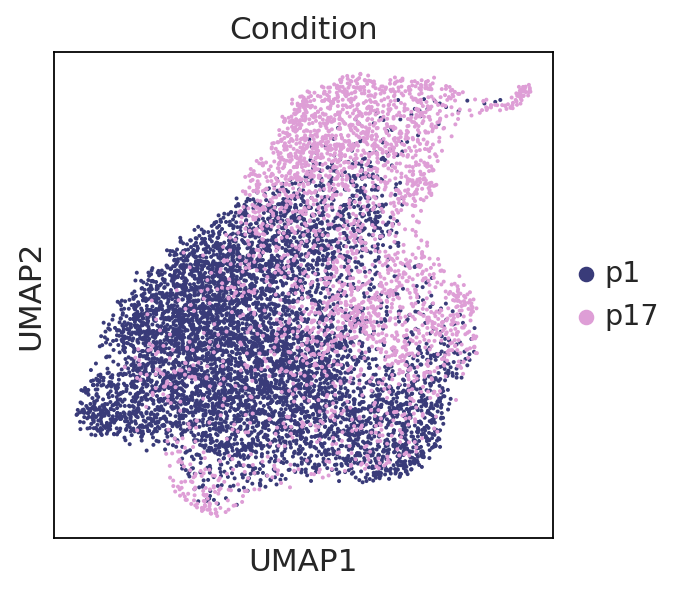

In [299]:
sc.pl.umap(adata, color="Condition", palette="tab20b")

In [300]:
adata.uns["Condition_colors"]

['#393b79', '#de9ed6']

In [308]:
#I will plot the changes in cell type composition in P1 vs P17
cell = pd.crosstab(index=adata.obs.Condition, 
                           columns=adata.obs.pred)

In [309]:
cell.columns

CategoricalIndex(['BEST4 enterocyte', 'Enteric neurons', 'FOXL1 FLC',
                  'G2M phase', 'Goblet progenitor', 'LGR5 stem', 'NAN',
                  'Neural crest cells', 'S phase', 'Uniform progenitor',
                  'early enterocyte 1', 'early enterocyte 2', 'enterocyte',
                  'mesoderm 1'],
                 categories=['BEST4 enterocyte', 'Enteric neurons', 'FOXL1 FLC', 'G2M phase', 'Goblet progenitor', 'LGR5 stem', 'NAN', 'Neural crest cells', ...], ordered=False, name='pred', dtype='category')

In [310]:
cell.columns =['BEST4 enterocyte', 'Enteric neurons', 'FOXL1 FLC',
                  'G2M phase', 'Goblet progenitor', 'LGR5 stem', 'NAN',
                  'Neural crest cells', 'S phase', 'Uniform progenitor',
                  'early enterocyte 1', 'early enterocyte 2', 'enterocyte',
                  'mesoderm 1']
cell["Pred"]=cell.index
cell_raw=pd.melt(cell, id_vars=['Pred'])
result = cell_raw.pivot(index='variable', columns='Pred', values='value')

In [311]:
result = result.drop(['NAN', 'Enteric neurons', 'FOXL1 FLC','Neural crest cells','mesoderm 1'], axis=0)

In [312]:
row_order = ['LGR5 stem','G2M phase', 'S phase','Uniform progenitor', 'early enterocyte 1', 'early enterocyte 2', 
             'enterocyte','BEST4 enterocyte','Goblet progenitor']
result = result.reindex(row_order, axis=0)

In [313]:
result

Pred                  p1   p17
variable                      
LGR5 stem           4183   199
G2M phase            666   437
S phase              600   150
Uniform progenitor   139     0
early enterocyte 1    60     1
early enterocyte 2     8     0
enterocyte            10    69
BEST4 enterocyte       6    93
Goblet progenitor     29  1561

In [314]:
epi_result = result.T
cols = list(epi_result.columns)
epi_result[cols] =epi_result[cols].div(epi_result[cols].sum(axis=1), axis=0).multiply(100)

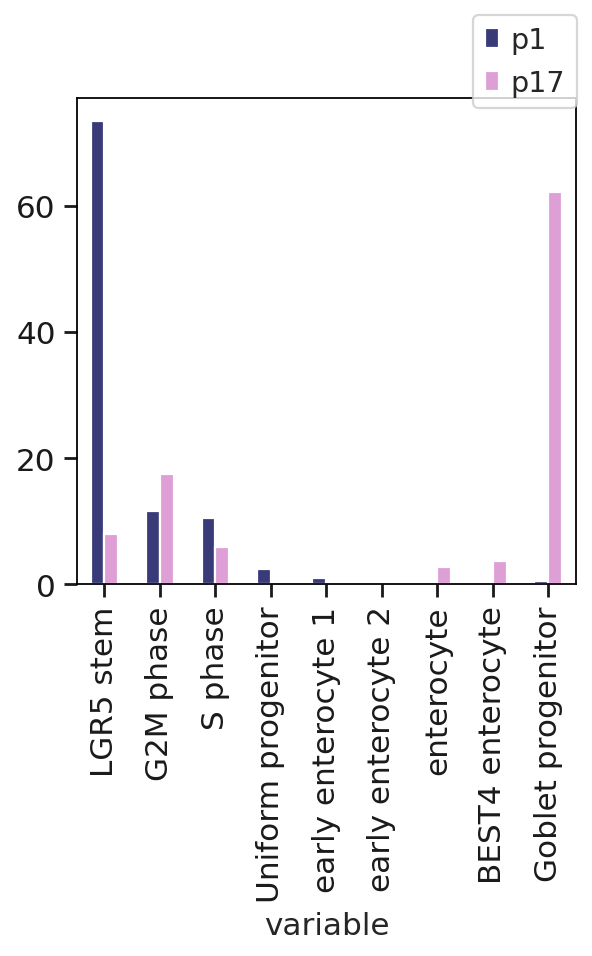

In [315]:
ax = epi_result.transpose().plot.bar(rot=90, color = {"p1" : '#393b79', "p17" : '#de9ed6'})
horiz_offset = 1.03
vert_offset = 1.2
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
ax.grid(None)

In [316]:
#crypt-villus axis scoring
sc.tl.score_genes(adata, ["SEPP1", "CEACAM7","PLAC8", "CEACAM1", "TSPAN1", "CEACAM5", "CEACAM6", "IFI27", "DHRS9", 
                        "KRT20", "RHOC", "CD177", "PKIB", "HPGD" ,"LYPD8", "APOBEC1","APOB","APOA4","APOA1","NPC1L1",
                     "EGFR","KLF4","ENPP3", "NT5E", "SLC28A2","ADA"], use_raw=True)

computing score 'score'
    finished: added
    'score', score of gene set (adata.obs).
    850 total control genes are used. (0:00:00)


In [317]:
adata.obs["pred"]  = pd.Series(pd.Categorical
                                (adata.obs["pred"] ,
                                 categories=['LGR5 stem','G2M phase', 'S phase','Uniform progenitor', 'early enterocyte 1', 'early enterocyte 2', 
             'enterocyte','BEST4 enterocyte','Goblet progenitor',
             'Neural crest cells','Enteric neurons','mesoderm 1', 'FOXL1 FLC', 'NAN']),index=adata.obs_names)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


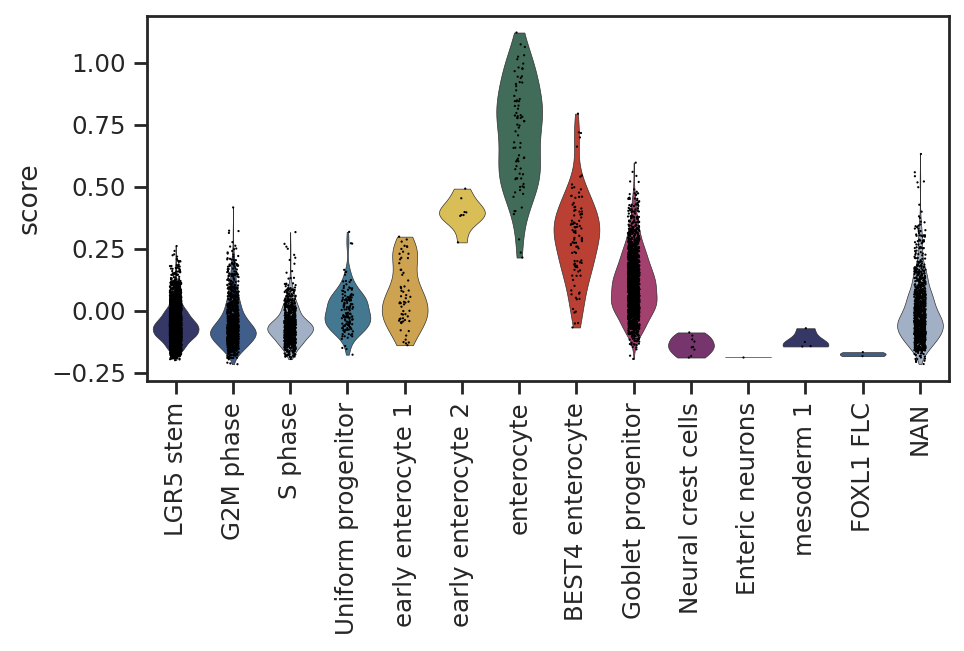

In [318]:
#crypt-villus axis score plotting
sns.set(style="ticks",rc={'figure.figsize':(6,3)})
sc.pl.violin(adata, "score", groupby="pred",linewidth=0.3
             , rotation=90,palette=['#2D306E', '#355A95', '#9BAFCA', '#367D9D', '#E2A83B', '#EECB43',
       '#3B735B', '#CF2E1D', '#B2316D', '#822A76', '#ED6497'])

In [319]:
#exclude cells that are not confidently assigned a label
subset = adata[adata.obs.pred.isin(['LGR5 stem','G2M phase', 'S phase','Uniform progenitor', 'early enterocyte 1', 'early enterocyte 2', 
             'enterocyte','BEST4 enterocyte','Goblet progenitor'])]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


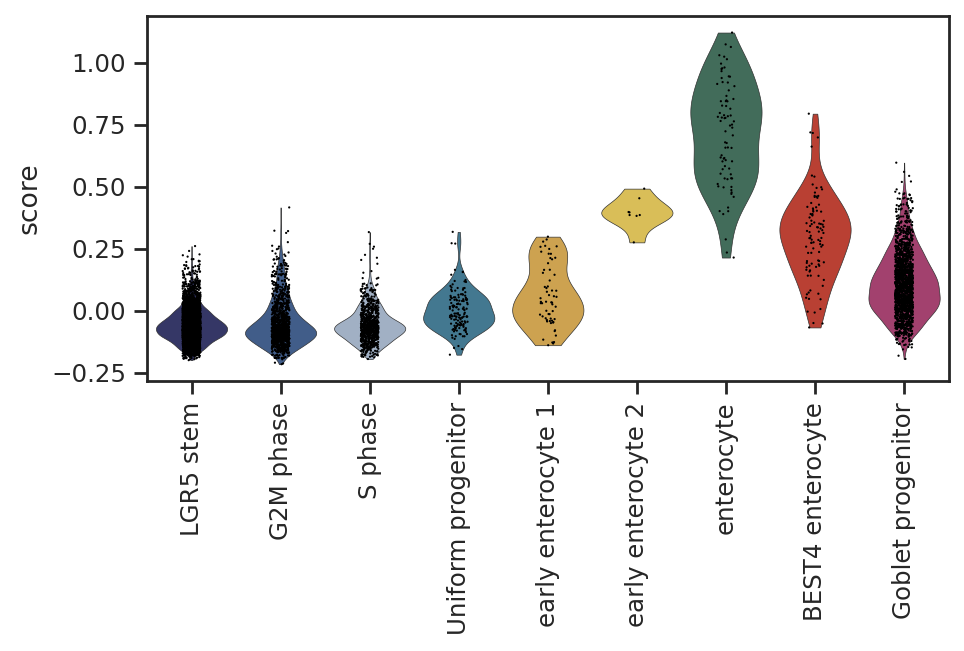

In [320]:
#crypt-villus axis score plotting
sns.set(style="ticks",rc={'figure.figsize':(6,3)})
sc.pl.violin(subset, "score", groupby="pred",linewidth=0.3
             , rotation=90,palette=['#2D306E', '#355A95', '#9BAFCA', '#367D9D', '#E2A83B', '#EECB43',
       '#3B735B', '#CF2E1D', '#B2316D', '#822A76', '#ED6497'])

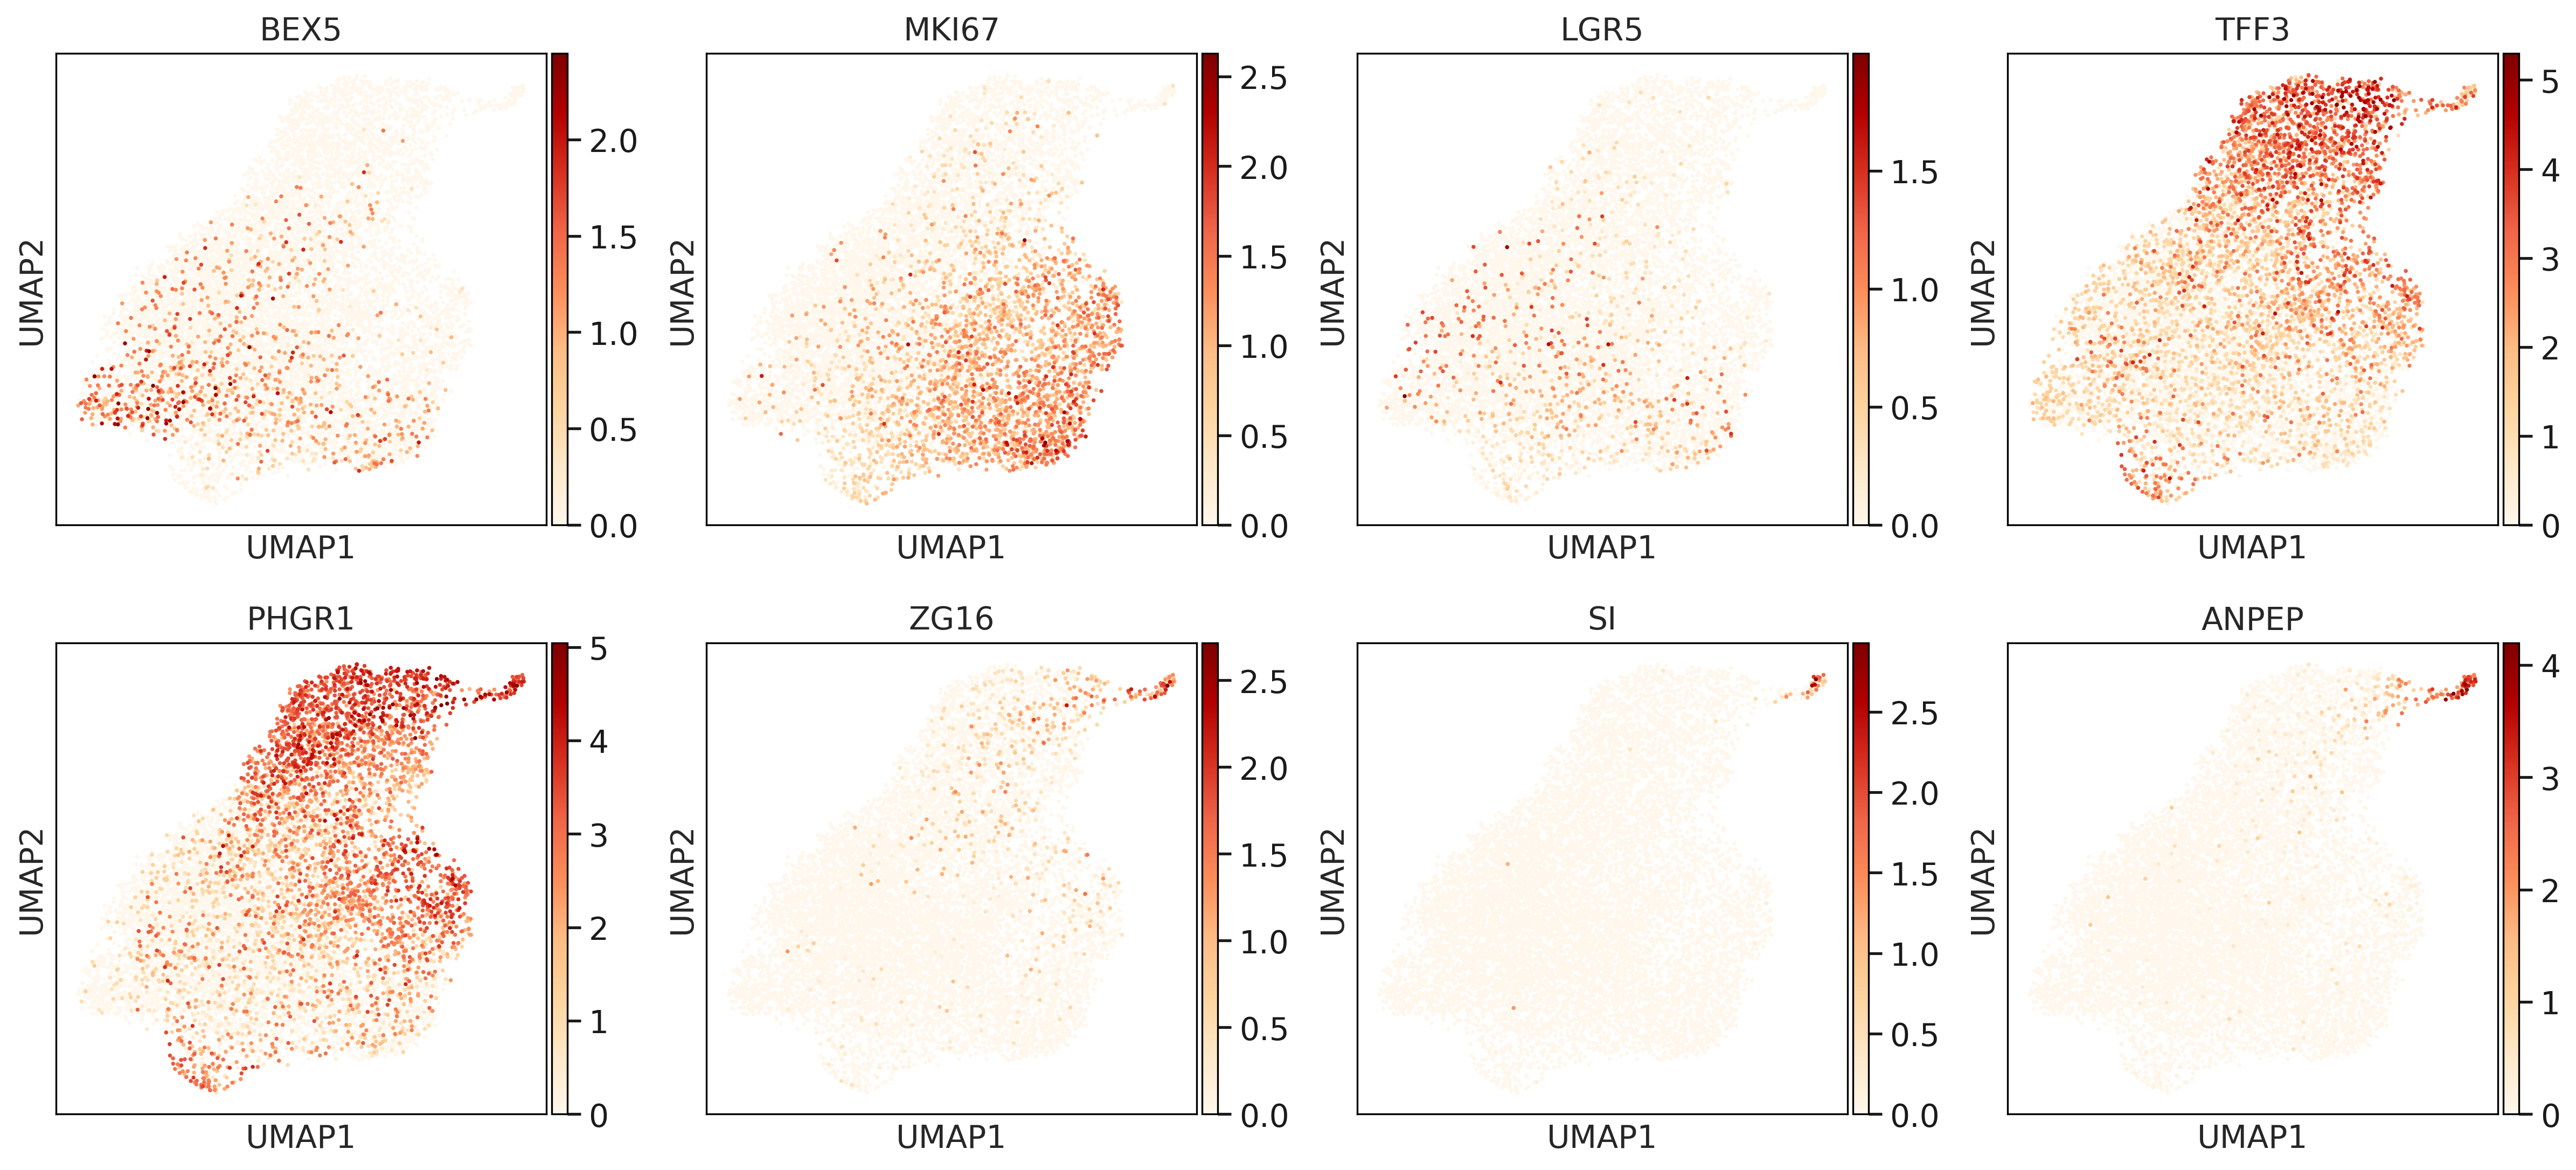

In [321]:
#Supplementary FigC
sc.settings.set_figure_params(dpi=150, color_map='OrRd', transparent=True,ipython_format="png2x")
sc.pl.umap(adata, color=["BEX5","MKI67","LGR5","TFF3","PHGR1",
                         "ZG16","SI","ANPEP"],ncols=4)

In [322]:
adata.write("/mnt/Dec2020/fetal_organoidp1p17_normalised_old.h5ad")

END